In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib
#Each time Matplotlib loads, 
#it defines a runtime configuration (rc) containing the default styles for every plot element you create. ... 
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [223]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [224]:
df['Month'].dtype

dtype('O')

In [225]:
df.isnull().sum()

Month          0
#Passengers    0
dtype: int64

In [226]:
df['Month'].min(), df['Month'].max()

('1949-01', '1960-12')

# Data PreProcessing

Convert Month Column to datetime

In [227]:
df['Month'] = pd.to_datetime(df['Month'])

In [228]:
df['Month'].min(), df['Month'].max()

(Timestamp('1949-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

Set Month as index

In [229]:
df = df.reset_index()

In [230]:
df = df.set_index('Month')

In [231]:
df.head()

,index,#Passengers
Month,,
1949-01-01,0,112
1949-02-01,1,118
1949-03-01,2,132
1949-04-01,3,129
1949-05-01,4,121


In [232]:
df = df.drop('index', axis = 1)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Data Visualization

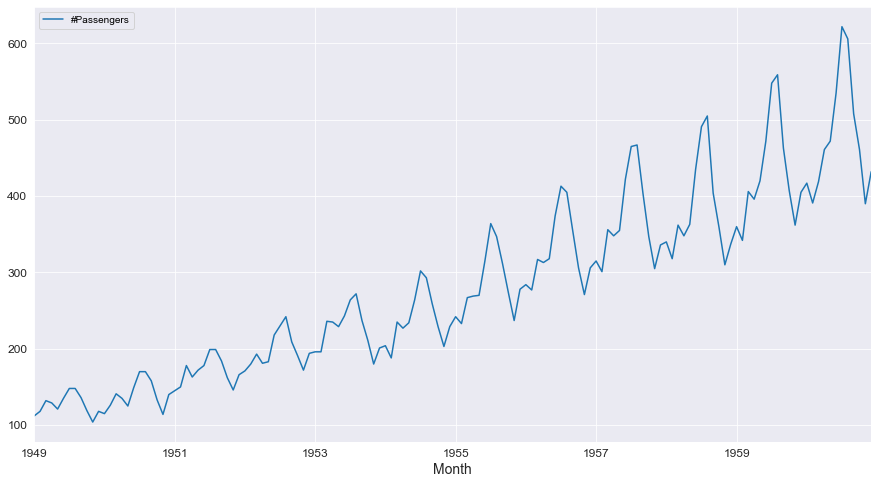

In [233]:
df.plot(figsize=(15, 8))
plt.show()

The above plot shows an upward trend and a seasonality(over a period of every two years).

#### Since all the values are positive, let's view a two-way plot

In [234]:
x = df.index
y = df['#Passengers'].values

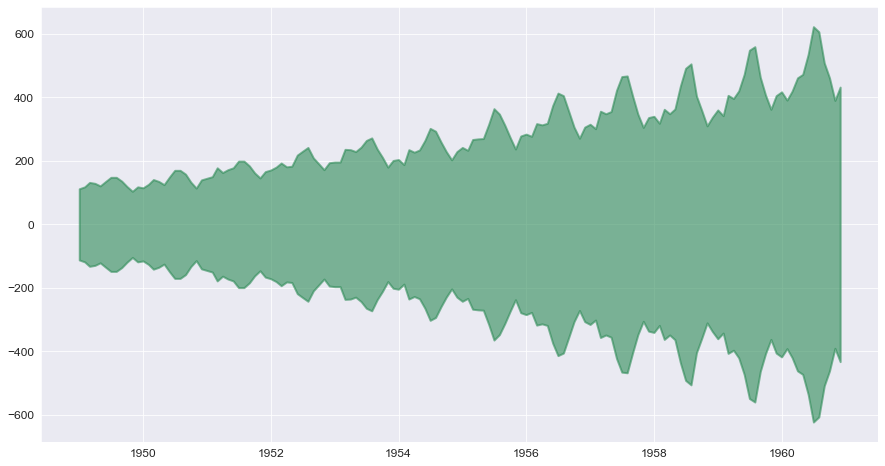

In [235]:
plt.figure(figsize=(15, 8))
plt.fill_between(x = x, y1=y, y2=-y, alpha = 0.6, color = 'seagreen', linewidth = 2)
plt.show()

Time series exhibits a multiplicative seasonality

# Test Stationarity of TS

ADF Testing

The null hypothesis H0 : that the time series is non stationary

The alternative hypothesis HA : that the time series is stationary

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary. This confirms our original observation which we initially saw in the visual test.

In [236]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(ts):
    print("Results for adfuller test: \n")
    adfullertest = adfuller(ts)
    adfullerout = pd.Series(adfullertest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(adfullertest)
    print('*'*10)
    for k, val in adfullertest[4].items():
        adfullerout['Critical Values (%s)'%k] = val
    print(adfullerout)

In [237]:
adfuller_test(df['#Passengers'])

Results for adfuller test: 

(0.8153688792060543, 0.9918802434376411, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 996.692930839019)
**********
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Values (1%)            -3.481682
Critical Values (5%)            -2.884042
Critical Values (10%)           -2.578770
dtype: float64


# Making the TS Stationary

### 1) Differencing

In [238]:
df['#Passengers'][:5]

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [239]:
df['#Passengers'].shift(1)[:5]

Month
1949-01-01      NaN
1949-02-01    112.0
1949-03-01    118.0
1949-04-01    132.0
1949-05-01    129.0
Name: #Passengers, dtype: float64

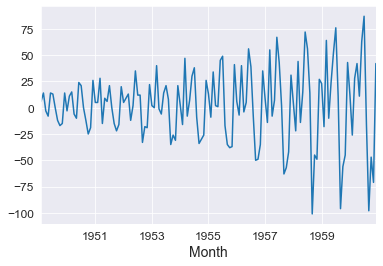

In [240]:
Passenger_diff = df['#Passengers'] - df['#Passengers'].shift(1)
Passenger_diff.dropna().plot()

### 2) Seasonal Differencing

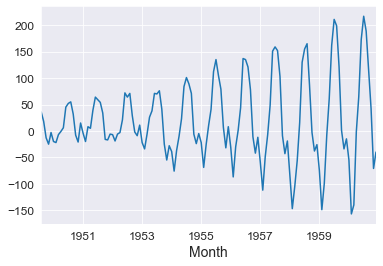

In [241]:
n = 7
Passenger_diff = df['#Passengers'] - df['#Passengers'].shift(n)
Passenger_diff.dropna().plot()

##  Transformation

Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. 

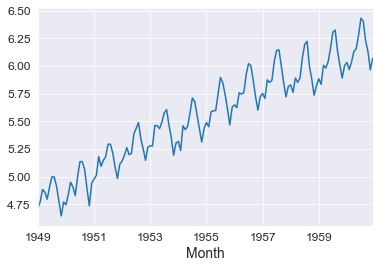

In [242]:
Passengers_log = np.log(df['#Passengers'])
#Passengers_log_diff = Passengers_log - Passengers_log.shift(1)
Passengers_log.dropna().plot()

## For simplicity, let's choose log transformation ,the reason for doing this is that we can revert back to the original scale during forecasting.

In [244]:
#Passengers_log_diff.dropna(inplace=True)
Passengers_log.dropna(inplace=True)

In [245]:
adfuller_test(Passengers_log)

Results for adfuller test: 

(-1.7170170891069625, 0.4223667747703904, 13, 130, {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, -445.3990312497209)
**********
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Values (1%)            -3.481682
Critical Values (5%)            -2.884042
Critical Values (10%)           -2.578770
dtype: float64


The Time Series is now Stationary

# Time Series forecasting with ARIMA

In [246]:
import itertools
import statsmodels.api as sm

In [247]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [248]:
y = Passengers_log

In [249]:
AIC_df = pd.DataFrame({}, columns=['params', 'seasonal_params', 'AIC'])

for param in pdq:
    for seasonal_params in seasonal_pdq:
        try:
            mod = sm.tsa.SARIMAX(y, 
                          order=param, seasonal_order=seasonal_params,
                          enforce_invertibility=False,
                          enforce_stationarity=False)
            results = mod.fit()
            temp = pd.DataFrame([(param, seasonal_params, results.aic)], columns=['params', 'seasonal_params', 'AIC'])
            AIC_df = AIC_df.append(temp, ignore_index = True)
            del temp
        except:
            continue

E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\anaconda\lib

E:\notebooks\anaconda\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\notebooks\ana

In [250]:
AIC_df.head()

,params,seasonal_params,AIC
0,"(0, 0, 0)","(0, 0, 0, 12)",898.736749
1,"(0, 0, 0)","(0, 0, 1, 12)",687.374902
2,"(0, 0, 0)","(0, 1, 0, 12)",-150.625773
3,"(0, 0, 0)","(0, 1, 1, 12)",-179.241230
4,"(0, 0, 0)","(1, 0, 0, 12)",-344.536297


In [251]:
min_aic = AIC_df.sort_values(by='AIC').iloc[0]
min_aic

params                 (1, 0, 1)
seasonal_params    (1, 0, 1, 12)
AIC                     -477.619
Name: 45, dtype: object

# Fitting the ARIMA Model

In [252]:
mod = sm.tsa.SARIMAX(y, 
                          order=(1, 0, 1), seasonal_order=(1, 0, 1, 12),
                          enforce_invertibility=False,
                          enforce_stationarity=False)
results = mod.fit()

E:\notebooks\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [253]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.102      0.000       0.865       1.019
ma.L1         -0.3803      0.093     -4.092      0.000      -0.562      -0.198
ar.S.L12       1.0200      0.003    302.487      0.000       1.013       1.027
ma.S.L12      -0.5747      0.107     -5.387      0.000      -0.784      -0.366
sigma2         0.0013      0.000      9.240      0.000       0.001       0.002


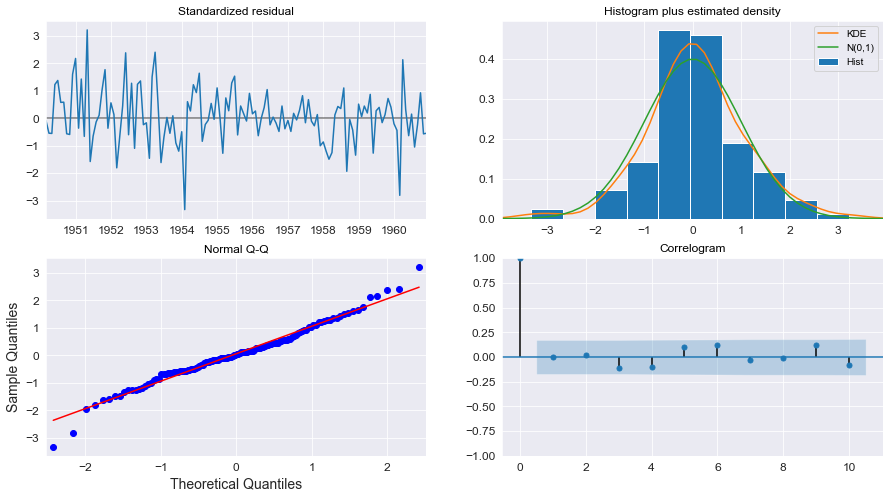

In [254]:
results.plot_diagnostics(figsize = (15, 8))
plt.show()

# Validating Forecasts

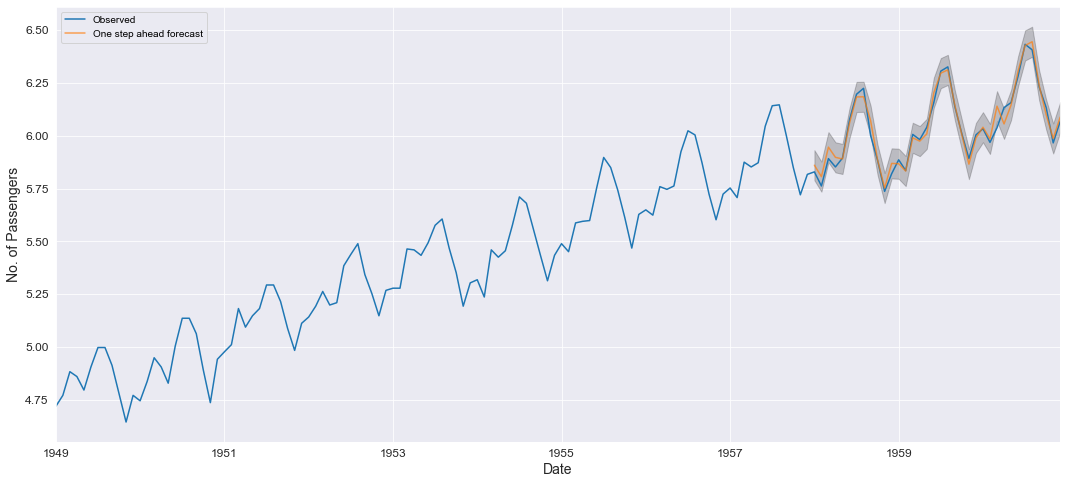

In [255]:
pred = results.get_prediction(start = pd.to_datetime('1958-01-01'), dynamic = False)
pred_ci = pred.conf_int()

plt.figure(figsize=(18, 8))
ax = y['1949':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax, label = 'One step ahead forecast', alpha = 0.7)
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], 
               alpha = 0.2, 
               color = 'k')
plt.legend()
plt.xlabel('Date')
plt.ylabel('No. of Passengers')
plt.show()

In [256]:
y_forecasted = pred.predicted_mean
y_truth = y['1958':]
mse = ((y_truth - y_forecasted)**2).mean()
mse

0.0012090197458520815

In [257]:
rmse = np.sqrt(mse)
rmse

0.03477096124429236

# Producing and Visualizing Forecasts

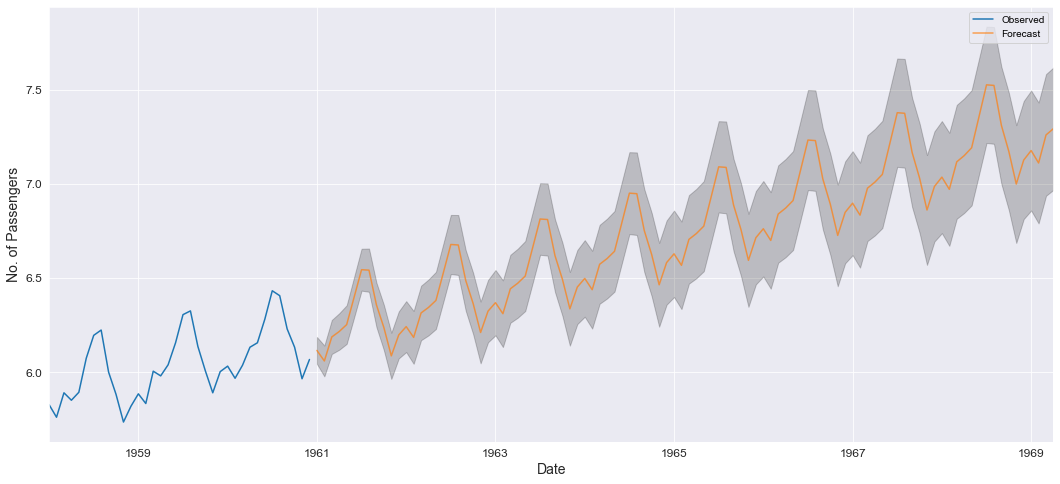

In [258]:
pred_for = results.get_forecast(steps = 100)
pred_ci = pred_for.conf_int()

plt.figure(figsize=(18, 8))
ax = y['1958':].plot(label = 'Observed')
pred_for.predicted_mean.plot(ax = ax, label = 'Forecast', alpha = 0.7)
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], 
               alpha = 0.2, 
               color = 'k')
plt.legend()
plt.xlabel('Date')
plt.ylabel('No. of Passengers')
plt.show()

# Back to Original Data

Take Exponential

In [259]:
#Take exponential
pred_for = np.exp(pred_for.predicted_mean)
pred_ci = np.exp(pred_ci)
print(type(pred_for))

<class 'pandas.core.series.Series'>


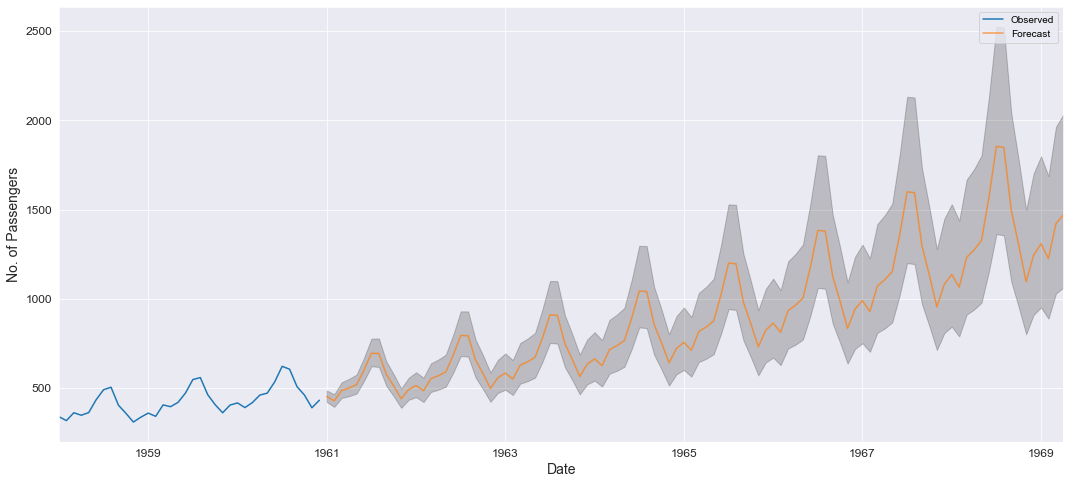

In [261]:
plt.figure(figsize=(18, 8))
ax = np.exp(y)['1958':].plot(label = 'Observed')
pred_for.plot(ax = ax, label = 'Forecast', alpha = 0.7)
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1], 
               alpha = 0.2, 
               color = 'k')
plt.legend()
plt.xlabel('Date')
plt.ylabel('No. of Passengers')
plt.show()